In [1]:
import sys
sys.path.append('..')
import gdspy
import numpy as np
from importlib import reload
#import libraries.conformal_mapping as cm
#import libraries.general_design_functions as gdf
#import libraries.general_sample_creator as creator
#from  ..libraries import general_design_functions as gdf
#fr
from copy import deepcopy
from QCreator import elements
from QCreator import general_sample_creator as creator

In [2]:
tl_core = 20
tl_gap = 12
tl_ground = 10

resonator_core = 8
resonator_gap = 7
resonator_ground = 4

pad_offset = 1000
pad_element_offset = 1000

coupler_start = pad_offset + pad_element_offset
coupler_delta = 500
coupler_length = 300
num_couplers = 1

# Transmission line with resonator (failed version)

In [3]:
reload(gdspy)
reload(creator)
reload(elements)

layers_configuration = {
    'total':0,
    'restricted area':10,
    'for removing':100,
    'JJs':1,
    'air bridges':2,
    'air bridge pads':3,
    'vertical gridlines':15,
    'horizontal gridlines':16
}
sample = creator.Sample('4_qubits',layers_configuration)

#specify sample vertical and horizontal lengths
sample.chip_geometry.sample_vertical_size=4.7e3
sample.chip_geometry.sample_horizontal_size=9.7e3

central_line_y = sample.chip_geometry.sample_vertical_size/2

chip_edge_ground = elements.ChipEdgeGround(sample.chip_geometry, sample.layer_configuration, sample.pads)
sample.add(chip_edge_ground)

# 1. Create contact pads:

p1 = elements.Pad('p1', (pad_offset,  central_line_y), np.pi, tl_core, tl_gap, tl_ground, 
                  layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry, 
                  **elements.default_pad_geometry())
p2 = elements.Pad('p2', (sample.chip_geometry.sample_horizontal_size-pad_offset,  central_line_y), 
                  0, tl_core, tl_gap, tl_ground, 
                  layer_configuration=sample.layer_configuration, chip_geometry=sample.chip_geometry, 
                  **elements.default_pad_geometry())
sample.add(p1)
sample.add(p2)

def draw_single_resonator(coupler_start_x, coupler_start_y, coupler_length,
                         resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width,
                         closed_end_meander_length, open_length):
    # 2. Create main copler:

    main_coupler = elements.CPWCoupler('TL-resonator coupler', [(coupler_start_x, central_line_y), 
                                                                (coupler_start_x+coupler_length, central_line_y)],
                                       [resonator_core, resonator_ground, tl_core],
                                       [resonator_gap, resonator_gap, tl_gap, tl_gap],
                                       tl_ground, sample.layer_configuration, r=100)
    sample.add(main_coupler)

    # 3. Create fanout to create closed end of resonator
    fanout_for_closed_end = sample.fanout(o=main_coupler, port='port1', name='closed end resonator fanout', grouping=[1, 3])

    # 4. 
    g1 = sample.ground(o=fanout_for_closed_end, port='center', name='cl1', grounding_width=grounding_width, grounding_between = [(2,3)])

    # 6. Create closed meander of resonator
    closed_end_meander = sample.connect_meander(name='closed end', o1=fanout_for_closed_end, port1='up',
                                                meander_length=closed_end_meander_length,restricted_scale=400, constant_scale=900, radius=40)
    # 7. Create grounding of resonator
    resonator_ground_ = sample.ground(o=closed_end_meander, port='port2', name='resonator ground', grounding_width=30, grounding_between = [(0,2)])
   
    # 8. Create fanout to create open end of resonator
    fanout_for_open_end = sample.fanout(o=main_coupler, port='port2', name='open end resonator fanout', grouping=[1, 3])

    # 9. 
    g2 = sample.ground(o=fanout_for_open_end, port='center', name='cl2', grounding_width=10, grounding_between = [(0,1)])

    # 10. Create open end of resonator
    open_end_resonator = elements.OpenEnd(name='open end',position=(fanout_for_open_end.get_terminals()['down'].position[0],
                                                                   fanout_for_open_end.get_terminals()['down'].position[1]-open_length),
                                         w=resonator_core,
                                         s=resonator_gap,
                                         g=tl_ground,
                                         orientation=np.pi/2,
                                         layer_configuration=sample.layer_configuration,
                                         gap_length=20,
                                         ground_length=10,
                                         cap=1e-15)
    sample.add(open_end_resonator)
    # 11. Connect open end with the coupler part of the resonator
    sample.connect_cpw(fanout_for_open_end,open_end_resonator,'down','wide',name='right open end',points=[])
    
    return g1, g2
def draw_single_resonator_plus_qubit(coupler_start_x, coupler_start_y, coupler_length,
                         resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width,
                         closed_end_meander_length, coaxmon ):
    # 2. Create main copler:
    total_length=0
    main_coupler = elements.CPWCoupler('TL-resonator coupler', [(coupler_start_x, central_line_y), 
                                                                (coupler_start_x+coupler_length, central_line_y)],
                                       [resonator_core, resonator_ground, tl_core],
                                       [resonator_gap, resonator_gap, tl_gap, tl_gap],
                                       tl_ground, sample.layer_configuration, r=100)
    sample.add(main_coupler)
    total_length = total_length + coupler_length

    # 3. Create fanout to create closed end of resonator
    fanout_for_closed_end = sample.fanout(o=main_coupler, port='port1', name='closed end resonator fanout', grouping=[1, 3])

    # 4. 
    g1 = sample.ground(o=fanout_for_closed_end, port='center', name='cl1', grounding_width=grounding_width, 
                       grounding_between = [(2,3)])

    # 6. Create closed meander of resonator
    closed_end_meander = sample.connect_meander(name='closed end', o1=fanout_for_closed_end, port1='up',
                                                meander_length=closed_end_meander_length,restricted_scale=400, 
                                                constant_scale=900, radius=40)
    total_length = total_length + closed_end_meander_length
    # 7. Create grounding of resonator
    resonator_ground_ = sample.ground(o=closed_end_meander, port='port2', name='resonator ground', grounding_width=30, grounding_between = [(0,2)])
   
    # 8. Create fanout to create open end of resonator
    fanout_for_open_end = sample.fanout(o=main_coupler, port='port2', name='open end resonator fanout', grouping=[1, 3])

    # 9. 
    g2 = sample.ground(o=fanout_for_open_end, port='center', name='cl2', grounding_width=10, grounding_between = [(0,1)])

    # 10. Connect open end with the coupler part of the qubit
    open_end=sample.connect_cpw(fanout_for_open_end,coaxmon,'down','coupler1',name='right open end',points=[])
    total_length = total_length + open_end.length
    res_params = (total_length,open_end.z0,open_end.cl)
    
    return g1, g2, res_params

In [4]:
### make a coaxmon
# add coaxmons
shift=-1/10
phi1=1/5
Couplers2q=[elements.coaxmon.CoaxmonCoupler(arc_start=-1/6-1/100+shift,arc_finish=-3/6+1/100+shift,phi=-1/2,
                                          coupler_type= None, w =10,g=10),
          elements.coaxmon.CoaxmonCoupler(arc_start=1/6+1/100+shift,arc_finish=3/6-1/100+shift,phi=phi1,
                                          coupler_type='coupler', w =8,g=10,s=7),# for resonator
          elements.coaxmon.CoaxmonCoupler(arc_start=3/6+1/100+shift,arc_finish=5/6-1/100+shift,phi=1/2, 
                                          coupler_type=None, w =8,g=10,s=7), #one upper
          elements.coaxmon.CoaxmonCoupler(arc_start=-1/6+1/100+1+shift,arc_finish=1/6-1/100+1+shift,phi=1,
                                          coupler_type=None, w =10),
          elements.coaxmon.CoaxmonCoupler(arc_start=-1/6+1/100+shift,arc_finish=1/6-1/100+shift,phi=0,
                                          coupler_type=None, w =10,g=40),
          elements.coaxmon.CoaxmonCoupler(arc_start=-5/6+1/100+shift,arc_finish=-3/6-1/100+shift,phi=1,
                                          coupler_type='grounded',w=4,g=4)
]


jj_coaxmon = {'a1':30,
               'b1':0.8,
               'a2':0.45,
               'b2':0.243,
               'c1':0.243,
               'c2':10,
               'angle_qubit':-np.pi/2-np.pi/3,
               'angle_JJ': 0,
               'length':10,
               'width':4}
# add coaxmons 1st line
coaxmon= elements.coaxmon.Coaxmon(name='Coaxmon',center=(coupler_start+1000*0+500,central_line_y-1000),
                          center_radius = 100,
                          inner_couplers_radius = 140,
                          outer_couplers_radius = 200,
                          inner_ground_radius = 230,
                          outer_ground_radius = 250,
                          layer_configuration = sample.layer_configuration,
                          Couplers=Couplers2q,jj_params= jj_coaxmon,transformations={},
                          calculate_capacitance = True)

sample.add(coaxmon)
sample.draw_design()
g1, g2,res1 = draw_single_resonator_plus_qubit(coupler_start+1000*0, central_line_y, coupler_length,
                        resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width=10,
                        closed_end_meander_length=2300, coaxmon=coaxmon)

# coaxmon= elements.coaxmon.Coaxmon(name='Coaxmon',center=(coupler_start+1000*1+500,central_line_y-1000),
#                           center_radius = 100,
#                           inner_couplers_radius = 140,
#                           outer_couplers_radius = 200,
#                           inner_ground_radius = 230,
#                           outer_ground_radius = 250,
#                           layer_configuration = sample.layer_configuration,
#                           Couplers=Couplers2q,jj_params= jj_coaxmon,transformations={},
#                           calculate_capacitance = True)

# sample.add(coaxmon)
# sample.draw_design()
# g3, g4,_ = draw_single_resonator_plus_qubit(coupler_start+1000*1, central_line_y, coupler_length,
#                         resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width=10,
#                         closed_end_meander_length=2500, coaxmon=coaxmon)

# coaxmon= elements.coaxmon.Coaxmon(name='Coaxmon',center=(coupler_start+1000*2+500,central_line_y-1000),
#                           center_radius = 100,
#                           inner_couplers_radius = 140,
#                           outer_couplers_radius = 200,
#                           inner_ground_radius = 230,
#                           outer_ground_radius = 250,
#                           layer_configuration = sample.layer_configuration,
#                           Couplers=Couplers2q,jj_params= jj_coaxmon,transformations={},
#                           calculate_capacitance = True)

# sample.add(coaxmon)
# sample.draw_design()
# g5, g6,res3 = draw_single_resonator_plus_qubit(coupler_start+1000*2, central_line_y, coupler_length,
#                         resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width=10,
#                         closed_end_meander_length=3000, coaxmon=coaxmon)


# # 5. Create left part of transmission line
left_TL = sample.connect_cpw(o1=p1, o2=g1, port1='port', port2='narrow', name='left TL', points=[])
# # # 9. Create middle part of transmission line
# middle_TL = sample.connect_cpw(o1=g3, o2=g2, port1='narrow', port2='narrow', name='middle TL 1', points=[])
# # # 9. Create middle part of transmission line
# middle_TL = sample.connect_cpw(o1=g4, o2=g5, port1='narrow', port2='narrow', name='middle TL 2', points=[])
# # # 9. Create left part of transmission line
right_TL = sample.connect_cpw(o1=p2, o2=g2, port1='port', port2='narrow', name='right TL', points=[])

In [5]:
# grid_ground = elements.GridGround(sample.chip_geometry, sample.layer_configuration, sample.objects, 
#                                   width=4, period=500)
# sample.add(grid_ground)
design = sample.draw_design()
sample.watch()

E:\py38\lib\site-packages\gdspy\path.py:827: UserWarning: [GDSPY] Possible inconsistency found in `FlexPath` due to sharp corner.
  warnings.warn(


In [6]:
sample.draw_cap()

In [7]:
for i, qubit in enumerate(sample.qubits):
    sample.calculate_qubit_capacitance(cell= sample.qubit_cap_cells[i], qubit=qubit,
                                       mesh_volume=20)

Gds file has been writen here:  E:\Github2.0\QCreator\example_notebooks\4_qubits.gds
For 0 conductor total length is:  7244
For 1 conductor total length is:  2503
For 2 conductor total length is:  806
Sum : 10553
Data has been written into the file: E:\Github2.0\QCreator\example_notebooks\mesh_4k_data
Time for fastcap job is:  0.8877742290496826
Capacitance results have been writen here:  E:\Github2.0\QCreator\example_notebooks\mesh_4k_results
Capacitance value in:  nanofarads
[<map object at 0x0000016D643C8790>, <map object at 0x0000016D643C8D60>, <map object at 0x0000016D643C8AF0>]


In [8]:
res1

(3561.6296161098317, 56.784268722636455, 1.4656184980033523e-16)

In [9]:
47.8*1e-15/1.4656184980033523e-16+res1[0]

3887.771787930937

In [10]:
def get_coupling(resonator,qubit,res_fr,qubit_fr,kappa):
    scal_factor=1e-15
    claw_cap_total = sample.qubits[0].C['coupler1'][0]+sample.qubits[0].C['coupler1'][1]
    res_total_cap = resonator[0]/2*resonator[2]+claw_cap_total*scal_factor
    qubit_total_cap = (sample.qubits[0].C['coupler1'][1] + sample.qubits[0].C['qubit'])*scal_factor
    coupling_cap= sample.qubits[0].C['coupler1'][1]*scal_factor
    coupling = coupling_cap/np.sqrt(qubit_total_cap*res_total_cap)*np.sqrt(res_fr*qubit_fr)/2
    print(res_total_cap,qubit_total_cap,coupling_cap)
    return coupling*1e3

In [11]:
def get_qubit_resonator_parameters(resonator,qubit,res_fr,qubit_fr,kappa):
    from scipy.constants import hbar,h,e,c
    scal_factor=1e-15
    claw_cap_total = sample.qubits[0].C['coupler1'][0]+sample.qubits[0].C['coupler1'][1]
    res_total_cap = resonator[0]/2*resonator[2]+claw_cap_total*scal_factor
    qubit_total_cap = (sample.qubits[0].C['coupler1'][1] + sample.qubits[0].C['qubit'])*scal_factor
    coupling_cap= sample.qubits[0].C['coupler1'][1]*scal_factor
    coupling = coupling_cap/np.sqrt(qubit_total_cap*res_total_cap)*np.sqrt(res_fr*qubit_fr)/2
    alpha = -e**2/(2*qubit_total_cap)/h/1e9
    disp_shift=coupling**2/((qubit_fr-res_fr))/(1+(qubit_fr-res_fr)/(alpha))
    T=(1/kappa)*(2*np.pi*(qubit_fr-res_fr)/coupling)**2
    print(coupling,qubit_fr-res_fr,kappa/1e9)
    return alpha*1e3,coupling*1e3,disp_shift*1e3,T # in MHz/2/np.pi

In [12]:
def search_for_resonators_qubits(f,delta):
    res_modes = []
    qs=f/delta/2
    min_freq=2e9
    max_freq=10e9
    min_Q=1e3
    max_Q=1e9
    for mode_id in range(len(qs)):
        if min_Q<=qs[mode_id]<=max_Q and min_freq<=f[mode_id]/2/np.pi<=max_freq:
            res_modes.append(mode_id)
    print('Resonance frequencies are, GHz/2pi:',f[res_modes]/(2*np.pi)/1e9)
    print('Kappas are, MHz/2pi:',delta[res_modes]/2/np.pi/1e6)
    print('Quality factors are:',qs[res_modes])
    return (f[res_modes]/(2*np.pi)/1e9, delta[res_modes], qs[res_modes])

In [197]:
sys.elements

[Short ,
 Port p1,
 Port p2,
 L ,
 C Coaxmon qubit-ground,
 C Coaxmon qubit-coupler1,
 C Coaxmon coupler1-ground,
 TL TL-resonator coupler (n=3),
 TL closed end resonator fanout_group1 (n=2),
 TL closed end resonator fanout_group2 (n=1),
 R cl10,
 TL cl1 (n=1),
 TL closed end (n=1),
 Short ,
 TL open end resonator fanout_group0 (n=1),
 TL open end resonator fanout_group1 (n=2),
 R cl20,
 TL cl2 (n=1),
 TL right open end (n=1),
 TL left TL (n=1),
 TL right TL (n=1)]

In [198]:
sys.terminal_node_mapping

[[0],
 [15],
 [17],
 [0, 19],
 [0, 19],
 [19, 14],
 [14, 0],
 [1, 2, 3, 8, 9, 10],
 [1, 2, 4, 5],
 [3, 6],
 [5, 0],
 [4, 16],
 [6, 7],
 [7],
 [10, 13],
 [9, 8, 11, 12],
 [11, 0],
 [12, 18],
 [13, 14],
 [15, 16],
 [17, 18]]

In [34]:
sample.qubits[0].C['coupler1']=(40.7,7)

In [35]:
%%time
sys, connections, elements_ = sample.get_tls()
f, delta, modes = sys.get_modes()
# f[:10]/(2*np.pi)/1e9, delta[:10]/1e6,f[:10]/delta[:10]/2 
(res_fr,kappa)=search_for_resonators_qubits(f,delta)[:2]

Resonance frequencies are, GHz/2pi: [4.85158254 7.1743352 ]
Kappas are, MHz/2pi: [0.00042012 0.32428963]
Quality factors are: [5774074.07215871   11061.61680652]
Wall time: 564 ms


In [30]:
%%time
sys, connections, elements_ = sample.get_tls()
f, delta, modes = sys.get_modes()
# f[:10]/(2*np.pi)/1e9, delta[:10]/1e6,f[:10]/delta[:10]/2 
(res_fr,kappa)=search_for_resonators_qubits(f,delta)[:2]

Resonance frequencies are, GHz/2pi: [4.62065104 7.12969333]
Kappas are, MHz/2pi: [0.00109511 0.31667115]
Quality factors are: [2109672.55196507   11257.25122376]
Wall time: 553 ms


In [15]:
get_coupling(res1,sample.qubits[0],res_fr[0],res_fr[-1],kappa[-1])

3.087995124203574e-13 7.17e-14 7.1e-15


140.69641154173328

In [16]:
get_qubit_resonator_parameters(res1,sample.qubits[0],res_fr[0],res_fr[-1],kappa[-1])

0.1406964115417333 2.325497167161873 0.0020368092567231225


(-270.1566154066823,
 140.69641154173328,
 -1.1188762176840419,
 0.005295109730962717)

In [36]:
kappa[-1]/kappa[0]

771.9016702154858

In [32]:
754.9/289

2.6121107266435986

In [31]:
kappa[-1]/kappa[0]

289.1680947014977

In [33]:
((res_fr[0]-res_fr[-1])/0.14069)**2

318.0456830675684

In [109]:
sample.qubits[0].L=8e-9
sample.qubits[1].L=10e-9

(4.844140861068216, 7.173579760072692)

..\QCreator\general_sample_creator.py:337: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  s.append(np.linalg.lstsq(m, boundary)[0][a2[0]])


Wall time: 29.8 s


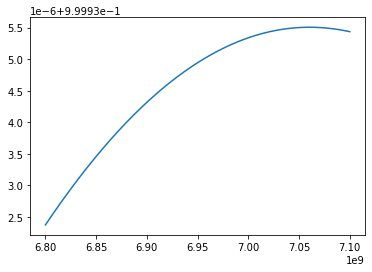

In [19]:
%%time
f_ = np.linspace(6.8e9, 7.1e9, 2001)
# s11 = sample.get_s21('p1', 'p1', f_)
s21 = sample.get_s21('p1', 'p2', f_)
from matplotlib import pyplot as plt
# plt.plot(f_, np.abs(s11))
plt.plot(f_, np.abs(s21))

# Playground

In [4]:
def draw_double_resonator(coupler_start_x, coupler_start_y, coupler_length,
                         resonator_core, resonator_ground, tl_core, resonator_gap, tl_gap, grounding_width,
                         closed_end_meander_length1, open_length1, closed_end_meander_length2, open_length2):
    # 2. Create main copler:

    main_coupler = elements.CPWCoupler('TL-resonator coupler', [(coupler_start, central_line_y), 
                                                                (coupler_start+coupler_length, central_line_y)],
                                       [resonator_core, resonator_ground, tl_core, resonator_ground, resonator_core],
                                       [resonator_gap, resonator_gap, tl_gap, tl_gap, resonator_gap, resonator_gap],
                                       tl_ground, sample.layer_configuration, r=100)
    sample.add(main_coupler)

    # 3. Create fanout to create closed end of resonator
    fanout_for_closed_end = sample.fanout(o=main_coupler, port='port1', name='closed end resonator fanout', grouping=[1, 4])

    # 4. 
    g1 = sample.ground(o=fanout_for_closed_end, port='center', name='cl1', grounding_width=grounding_width, grounding_between = [(0,1), (3,4)])

    # 6. Create closed meander of resonator
    closed_end_meander1 = sample.connect_meander(name='closed end 1', o1=fanout_for_closed_end, port1='up',
                                                meander_length=closed_end_meander_length1,restricted_scale=400, constant_scale=900, radius=0)
    
    closed_end_meander2 = sample.connect_meander(name='closed end 2', o1=fanout_for_closed_end, port1='down',
                                                meander_length=closed_end_meander_length2,restricted_scale=400, constant_scale=900, radius=0)

    # 7. Create fanout to create closed enfd of resonator
    fanout_for_open_end = sample.fanout(o=main_coupler, port='port2', name='open end resonator fanout', grouping=[1, 4])

    # 8. 
    g2 = sample.ground(o=fanout_for_open_end, port='center', name='cl2', grounding_width=10, grounding_between = [(0,1), (3,4)])

    # 10. Create closed meander of resonator
    open_end_resonator1 = elements.CPW(name='open end resonator 1', points=[fanout_for_open_end.get_terminals()['down'].position, 
                                                                         (fanout_for_open_end.get_terminals()['down'].position[0],
                                                                          fanout_for_open_end.get_terminals()['down'].position[1]-open_length1)],
                                      w=fanout_for_open_end.get_terminals()['down'].w, s=fanout_for_open_end.get_terminals()['down'].s,
                                      g=fanout_for_open_end.get_terminals()['down'].g, layer_configuration=sample.layer_configuration, r=25)
    sample.add(open_end_resonator1)
    sample.connections.append(((fanout_for_open_end, 'down', 0), (open_end_resonator1, 'port1', 0)))
    
    open_end_resonator2 = elements.CPW(name='open end resonator 2', points=[fanout_for_open_end.get_terminals()['up'].position, 
                                                                         (fanout_for_open_end.get_terminals()['up'].position[0],
                                                                          fanout_for_open_end.get_terminals()['up'].position[1]+open_length2)],
                                      w=fanout_for_open_end.get_terminals()['up'].w, s=fanout_for_open_end.get_terminals()['up'].s,
                                      g=fanout_for_open_end.get_terminals()['up'].g, layer_configuration=sample.layer_configuration, r=25)
    sample.add(open_end_resonator2)
    sample.connections.append(((fanout_for_open_end, 'up', 0), (open_end_resonator2, 'port1', 0)))

    # 11. Create grounding of resonator
    resonator_ground_1 = sample.ground(o=closed_end_meander1, port='port2', name='resonator ground 1', grounding_width=30, grounding_between = [(0,2)])
    resonator_ground_2 = sample.ground(o=closed_end_meander2, port='port2', name='resonator ground 2', grounding_width=30, grounding_between = [(0,2)])
    
    return g1, g2